# Imports

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
from PIL import ImageFile
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tempfile import TemporaryFile
import matplotlib.pyplot as plt
import cv2
import os
import shutil
import os
import gc
import time
import warnings

ImageFile.LOAD_TRUNCATED_IMAGES = True
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings('ignore') #ignore warnings

%matplotlib inline

In [2]:
# Making the code device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Utility Functions

In [3]:
def read_data(fname):
    """
    Reads .csv data and returns a dataframe
    """
    return pd.read_csv(fname)


def get_image_features(df):
    """
    Extract features from image i-e vectorize the image
    """
    img_name=[i for i in df['Image_name']]
    x_data = np.array( [np.array(image.load_img('./Images'+'/'+i+".jpg",target_size=(32,32))) for i in tqdm(df['Image_name'])])
    return x_data.reshape(np.shape(x_data)[0],np.shape(x_data)[1]*np.shape(x_data)[2]*np.shape(x_data)[-1]),img_name


def get_image_segments_features(df):
    """
    Extract features from image segments i-e vectorize the image segments
    """
    img_name=[i for i in df['Image_name']]
    x_data = np.array( [np.array(image.load_img('./Segments'+'/'+i+".jpg",target_size=(32,32))) for i in tqdm(df['Image_name'])])
    return x_data.reshape(np.shape(x_data)[0],np.shape(x_data)[1]*np.shape(x_data)[2]*np.shape(x_data)[-1]),img_name


def get_70_percent(df,elbow_value_):
    """
    Get 70% of images against each of our cluster
    Returns a dataframe with image names and cluster value
    """
    img_counts=df['kmeans_label'].value_counts()
    df_final = pd.DataFrame(columns = ['Image_name','label'])

    for i in range(elbow_value_):
        total_counts=img_counts[i]
        sum_=0
        for label, content in df.iterrows():
            if((content[2]==i) and (sum_/total_counts<0.7)):
                df_final=df_final.append(pd.DataFrame({"Image_name":[content[0]],"label":[content[2]]}))
                sum_+=1
    df_final.reset_index(inplace=True)
    df_final.drop(["index"],axis=1,inplace=True)
    return df_final


def kmean_img_clustering(elbow_k_value):
    """
    Gets image segments, and saves the segments in a separate 'Segments' folder
    All credits to: https://www.geeksforgeeks.org/image-segmentation-using-k-means-clustering/
    """
    try:
        os.mkdir("Segments")
    except:
        pass

    # Checking if the list is empty or not
    # If directory is not empty, images already exist
    if len(os.listdir("Segments"))==0:
        for i in df_final['Image_name']:
            # Read in the image
            image = cv2.imread('./Images/' + i+'.jpg')
            image = cv2.resize(image, (32, 32), interpolation = cv2.INTER_AREA)
            # Change color to RGB (from BGR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.imshow(image)
            pixel_vals = image.reshape((-1,1))
            # Convert to float type
            pixel_vals = np.float32(pixel_vals)
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)

            #then perform k-means clustering with number of clusters w.r.t our best k elbow value 
            #also random centres are initially choosed for k-means clustering
            k = elbow_k_value
            retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

            # convert data into 8-bit values
            centers = np.uint8(centers)
            segmented_data = centers[labels.flatten()]

            # reshape data into the original image dimensions
            segmented_image = segmented_data.reshape((image.shape))

            plt.imshow(segmented_image)
            pil_im = Image.fromarray(segmented_image)  
            pil_im.save('./Segments/'+i+'.jpg')
            
            
def get_img_features_in_df(df_final,img_features):
    """
    Gets image features in dataframe, for use in classical ML models
    """
    tmp_df=df_final.copy()
    tmp_df.set_index('Image_name', inplace=True) # Make 'name' the index
    filtered_dic={your_key:img_features[your_key] for your_key in df_final['Image_name']}
    filtered_df=pd.DataFrame.from_dict(filtered_dic,orient='index')
    filtered_df["label"] = np.nan
    for i in filtered_df.index:
        filtered_df.loc[i,'label']=tmp_df.loc[i,'label']
    return filtered_df            


def visualize_img_clusters(df,img_features):
    """
    Visualizes image clusters obtained through K-Means
    X axis has image vector mean value
    Y axis has image vector median value
    Labels(clusters) are color separated
    """
    tmp=get_img_features_in_df(df,img_features)
    tmp['median']=tmp.median(axis=1)
    tmp['avg']=tmp.mean(axis=1)
    tmp = tmp[['median','avg','label']]

    u_labels = np.unique(tmp.label)
    plt.figure(figsize=(10,7))
    for i in u_labels:
        plt.scatter(tmp[tmp['label']==i]['avg'],tmp[tmp['label']==i]['median'] , label = i)
    plt.xlabel("Image pixel mean")
    plt.ylabel("Image pixel median")
    plt.title("Image Clustering Visualization")
    plt.legend()
    plt.show()
            
    
def pretty_size(size):
    """Pretty prints a torch.Size object"""
    "Only used for debugging, not for use in our program"
    assert(isinstance(size, torch.Size))
    return " × ".join(map(str, size))


def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    "Only used for debugging, not for use in our program"
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print("%s:%s%s %s" % (type(obj).__name__, 
                                          " GPU" if obj.is_cuda else "",
                                          " pinned" if obj.is_pinned else "",
                                          pretty_size(obj.size())))
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
                                                   type(obj.data).__name__, 
                                                   " GPU" if obj.is_cuda else "",
                                                   " pinned" if obj.data.is_pinned else "",
                                                   " grad" if obj.requires_grad else "", 
                                                   " volatile" if obj.volatile else "",
                                                   pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass        
    print("Total size:", total_size)

# Utility Classes

In [56]:
class ImagesDataset(Dataset):
    """
    Custom Dataloader for our dataset.
    All credit goes to: https://github.com/aladdinpersson/Machine-Learning-Collection/blame/master/ML/Pytorch/Basics/custom_dataset_txt/loader_customtext.py
    """
    def __init__(self, dataframe, root_dir,transform = None):
        self.df = dataframe.copy()
        self.img = self.df['Image_name']
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        #convert image to 3 channel RGB, as some images in our dataset are >3 channels or <3 channels
        image=Image.open(self.root_dir+"/"+self.df.iloc[index, 0]+".jpg").convert("RGB")
        y_label = torch.tensor(int(self.df.iloc[index, 1]))
        if self.transform:
            image = self.transform(image)   
        return (image,y_label)

# CNN Model

In [57]:
class Net_CNN(nn.Module):
    def __init__(self,elbow_k):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, elbow_k))
        
    def forward(self, xb):
        return self.network(xb)


def predict_CNN(trainloader,testloader,net,criterion,optimizer,epochs=100):
    n_epochs=epochs
    loss_list=[]
    final_loss=list()
    tot_loss=0


    for epoch in range(n_epochs):
          for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs=inputs.to(device)
                labels=labels.to(device)
                #clear gradient 
                optimizer.zero_grad()
                #make a prediction 
                z=net(inputs)
                loss=criterion(z,labels)
                # calculate gradients of parameters 
                loss.backward()
                # update parameters 
                optimizer.step()
                
                
                loss_list.append(loss.detach().item())
                tot_loss+=loss.detach().item()
                if(i%8==7):
                        print(f'[{epoch+1}, {i+1:5d}] loss: {tot_loss/len(loss_list)}')
                        final_loss.append(tot_loss/len(loss_list))

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images=images.to(device)
            labels=labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (correct/total),final_loss

# ANN Model

In [58]:
class Net_ANN(nn.Module):
    """
    Network for images
    """
    def __init__(self,elbow_k):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, elbow_k)
        )
            
    def forward(self, x):
        return self.network(x)
    
    
    
def predict_ANN(trainloader,testloader,net,criterion,optimizer,epochs=100):
    n_epochs=epochs
    loss_list=[]
    final_loss=list()
    tot_loss=0


    for epoch in range(n_epochs):
          for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs=inputs.to(device)
                labels=labels.to(device)
                #clear gradient 
                optimizer.zero_grad()
                #make a prediction 
                z=net(inputs)
                loss=criterion(z,labels)
                # calculate gradients of parameters 
                loss.backward()
                # update parameters 
                optimizer.step()
                
                
                loss_list.append(loss.detach().item())
                tot_loss+=loss.detach().item()
                if(i%8==7):
                        print(f'[{epoch+1}, {i+1:5d}] loss: {tot_loss/len(loss_list)}')
                        final_loss.append(tot_loss/len(loss_list))

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images=images.to(device)
            labels=labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (correct/total),final_loss

# Machine Learning Models

In [59]:
def predict_NB(X_train,y_train,X_test,y_test):
    """
    Returns accuracy score after fitting 
    and predicting through Gaussian Naiive Bayes
    """
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    preds=clf.predict(X_test)
    return accuracy_score(y_test, preds),recall_score(y_test, preds, average='macro'),precision_score(y_test, preds, average='macro'),f1_score(y_test, preds, average='macro')


def predict_LogisticRegression(X_train,y_train,X_test,y_test):
    """
    Returns accuracy score after fitting 
    and predicting through Logistic Regression
    """
    clf = LogisticRegression(random_state=0)
    clf.fit(X_train, y_train)
    preds=clf.predict(X_test)
    return accuracy_score(y_test, preds),recall_score(y_test, preds, average='macro'),precision_score(y_test, preds, average='macro'),f1_score(y_test, preds, average='macro')


def predict_GradBoostCLF(X_train,y_train,X_test,y_test):
    """
    Returns accuracy score after fitting 
    and predicting through Gradient Boosting Classifier
    """
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
    clf.fit(X_train, y_train)
    preds=clf.predict(X_test)
    return accuracy_score(y_test, preds),recall_score(y_test, preds, average='macro'),precision_score(y_test, preds, average='macro'),f1_score(y_test, preds, average='macro')

# <br><br><br>

# Step 01: Sampling

In [8]:
#read data into a df
df=read_data("Data_labels.csv")
df

,Image_name,level
0,IMG_1,4
1,IMG_2,4
2,IMG_3,4
3,IMG_4,4
4,IMG_5,4
...,...,...
511,IMG_512,2
512,IMG_513,2
513,IMG_514,2
514,IMG_515,2


In [9]:
#get image features and respective image names
#and store them in dictionary, with image names as keys, and features as values
feat,name=get_image_features(df)
img_features=dict(zip(name,feat))

100%|████████████████████████████████████████████████████████████████████████████████| 516/516 [00:16<00:00, 30.59it/s]


In [10]:
#Using elbow method for optimal value of 'k'
optimal_elbow_k=0
if(os.path.exists('elbow_k.txt')==False): #Check if we have already saved our optimal k elbow value, used for speeding up code
    model=KMeans(n_clusters=5)
    visualizer=KElbowVisualizer(model,k=(4,20))
    optimal_elbow_k=visualizer.elbow_value_
    visualizer.fit(np.array(list(img_features.values())))
    with open('elbow_k.txt', 'w') as f:
        f.write(str(visualizer.elbow_value_))
    visualizer.show()
else: #If file already exists, just read it
    with open('elbow_k.txt') as f:
        optimal_elbow_k=int(f.readlines()[0])

In [11]:
#Predicting labels through k-means
kmeans=KMeans(n_clusters=optimal_elbow_k,random_state=0).fit(np.array(list(img_features.values())))
preds=kmeans.predict(np.array(list(img_features.values())))

#saving k-means labels in df
df['kmeans_label']=preds

In [12]:
df_final=get_70_percent(df,optimal_elbow_k)
df_final

,Image_name,label
0,IMG_20,0
1,IMG_22,0
2,IMG_25,0
3,IMG_27,0
4,IMG_36,0
...,...,...
359,IMG_280,7
360,IMG_290,7
361,IMG_291,7
362,IMG_292,7


### BONUS: Visualization of Image clustering

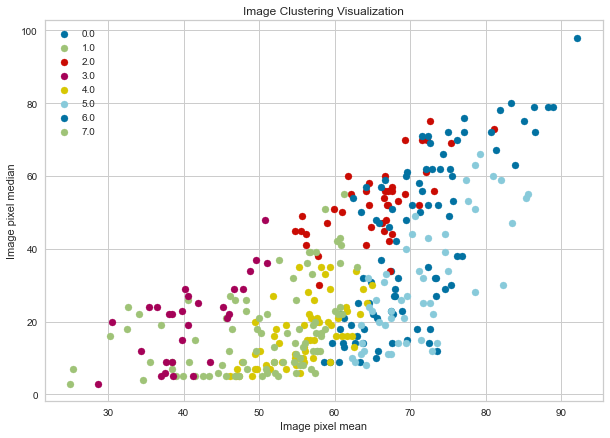

In [13]:
visualize_img_clusters(df_final,img_features) #Visualizing image clusters

# Step 02: Segmentation

In [14]:
kmean_img_clustering(optimal_elbow_k) #Performs image segmentation, and stores the segments in a separate 'Segments' folder

# Step 03: Image classification and analysis

In [60]:
clfs=['CNN','ANN','NB','LR','GradBoost']
clfs2=['NB','LR','GradBoost']
times_seg=list()
acc_seg=list()
times_orig=list()
acc_orig=list()

In [61]:
net_cnn = Net_CNN(optimal_elbow_k).to(device) #cnn
net_ann = Net_ANN(optimal_elbow_k).to(device) #ann
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(net_cnn.parameters(), lr=0.001)

#### Predicting segmented images

In [62]:
dataset = ImagesDataset(dataframe = df_final, root_dir = './Segments',transform = transforms.Compose(
    [
     transforms.Resize((32, 32)),
     transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
    ]))

train_set, test_set = torch.utils.data.random_split(dataset, [255,109])
dataloader_train = DataLoader(dataset = train_set, batch_size = 32, shuffle=True)
dataloader_test = DataLoader(dataset = test_set, batch_size = 32, shuffle=True)

In [63]:
#predicting segments through cnn 
t0=time.time()
acc,loss_cnn_seg=predict_CNN(dataloader_train,dataloader_test,net_cnn,criterion,optimizer,epochs=1000)
acc_seg.append(acc)
times_seg.append(time.time()-t0) #Storing time taken by CNN

[1,     8] loss: 2.076465219259262
[2,     8] loss: 2.0410356000065804
[3,     8] loss: 1.946071018775304
[4,     8] loss: 1.7962469048798084
[5,     8] loss: 1.6284904778003693
[6,     8] loss: 1.5172266326844692
[7,     8] loss: 1.4341962571655
[8,     8] loss: 1.3507705368101597
[9,     8] loss: 1.2798373326659203
[10,     8] loss: 1.221062508225441
[11,     8] loss: 1.1758194667371837
[12,     8] loss: 1.1288809667651851
[13,     8] loss: 1.081222774890753
[14,     8] loss: 1.0449144872171539
[15,     8] loss: 1.0240617071588833
[16,     8] loss: 0.9977631184738129
[17,     8] loss: 0.9686622065218056
[18,     8] loss: 0.9400005557884773
[19,     8] loss: 0.9091937416478207
[20,     8] loss: 0.8854008491151035
[21,     8] loss: 0.8790727006714969
[22,     8] loss: 0.8693469289520924
[23,     8] loss: 0.8516066024970749
[24,     8] loss: 0.8299189495543638
[25,     8] loss: 0.8107042956352234
[26,     8] loss: 0.794171821540938
[27,     8] loss: 0.7753699826145614
[28,     8] loss: 

[218,     8] loss: 0.13132012072362578
[219,     8] loss: 0.1307205040278375
[220,     8] loss: 0.13012633817380537
[221,     8] loss: 0.12953754897138528
[222,     8] loss: 0.12895406407179877
[223,     8] loss: 0.12837581184769697
[224,     8] loss: 0.12780272259946107
[225,     8] loss: 0.12723472700662886
[226,     8] loss: 0.12667175773013767
[227,     8] loss: 0.12611374838365094
[228,     8] loss: 0.1255606337313471
[229,     8] loss: 0.12501234936894232
[230,     8] loss: 0.12446883256145429
[231,     8] loss: 0.1239300212318427
[232,     8] loss: 0.12339585481816828
[233,     8] loss: 0.1228662732058525
[234,     8] loss: 0.12234121769639147
[235,     8] loss: 0.12182063061847348
[236,     8] loss: 0.12130445520449995
[237,     8] loss: 0.1207926354642855
[238,     8] loss: 0.12028511653685324
[239,     8] loss: 0.11978184468610967
[240,     8] loss: 0.11928276638730233
[241,     8] loss: 0.11878782966198148
[242,     8] loss: 0.1182969831883765
[243,     8] loss: 0.1178101763

[428,     8] loss: 0.06688812720434179
[429,     8] loss: 0.06673221206451704
[430,     8] loss: 0.06657702210953771
[431,     8] loss: 0.0664225522900405
[432,     8] loss: 0.06626879760797065
[433,     8] loss: 0.0661157530876813
[434,     8] loss: 0.06596341383447989
[435,     8] loss: 0.06581177497934479
[436,     8] loss: 0.06566083171287657
[437,     8] loss: 0.06551057925326734
[438,     8] loss: 0.06536101287095224
[439,     8] loss: 0.06521212786823756
[440,     8] loss: 0.06506391960566894
[441,     8] loss: 0.06491638348454505
[442,     8] loss: 0.06476951493819788
[443,     8] loss: 0.06462330945312918
[444,     8] loss: 0.06447776254388357
[445,     8] loss: 0.06433286976930765
[446,     8] loss: 0.06418862673693664
[447,     8] loss: 0.06404502907049206
[448,     8] loss: 0.06390207246713726
[449,     8] loss: 0.06375975263122158
[450,     8] loss: 0.0636180653190975
[451,     8] loss: 0.06347700632961795
[452,     8] loss: 0.0633365714852551
[453,     8] loss: 0.06319675

[638,     8] loss: 0.04487175680633872
[639,     8] loss: 0.04480153519923606
[640,     8] loss: 0.044731533034303536
[641,     8] loss: 0.044661749285330905
[642,     8] loss: 0.044592182929389865
[643,     8] loss: 0.044522832953957085
[644,     8] loss: 0.044453698347270185
[645,     8] loss: 0.04438477811322669
[646,     8] loss: 0.04431607125028878
[647,     8] loss: 0.044247576772397275
[648,     8] loss: 0.0441792936939468
[649,     8] loss: 0.04411122104350741
[650,     8] loss: 0.04404335784363328
[651,     8] loss: 0.043975703129299056
[652,     8] loss: 0.04390825594377271
[653,     8] loss: 0.04384101533395149
[654,     8] loss: 0.04377398035373334
[655,     8] loss: 0.043707150058390744
[656,     8] loss: 0.043640523511155
[657,     8] loss: 0.04357409978361283
[658,     8] loss: 0.043507877951419645
[659,     8] loss: 0.04344185709518044
[660,     8] loss: 0.04337603630068534
[661,     8] loss: 0.04331041465941586
[662,     8] loss: 0.04324499126902378
[663,     8] loss: 

[846,     8] loss: 0.033839479495526056
[847,     8] loss: 0.03379952739381359
[848,     8] loss: 0.03375966951898638
[849,     8] loss: 0.03371990553688413
[850,     8] loss: 0.03368023511693365
[851,     8] loss: 0.03364065792946249
[852,     8] loss: 0.03360117364571125
[853,     8] loss: 0.03356178193930746
[854,     8] loss: 0.03352248248526661
[855,     8] loss: 0.03348327495966782
[856,     8] loss: 0.033444159039893256
[857,     8] loss: 0.03340513440663625
[858,     8] loss: 0.03336620074043306
[859,     8] loss: 0.03332735772281792
[860,     8] loss: 0.03328860503675388
[861,     8] loss: 0.033249942369101934
[862,     8] loss: 0.03321136940526597
[863,     8] loss: 0.03317288583390088
[864,     8] loss: 0.033134491344685664
[865,     8] loss: 0.03309618562732773
[866,     8] loss: 0.03305796837629808
[867,     8] loss: 0.03301983928413346
[868,     8] loss: 0.03298179804677762
[869,     8] loss: 0.03294384436229992
[870,     8] loss: 0.03290597792615219
[871,     8] loss: 0.

In [64]:
#predicting segments through ann
net_ann = Net_ANN(optimal_elbow_k).to(device) #ann
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(net_ann.parameters(), lr=0.001)
t0=time.time()
acc,loss_ann_seg=predict_ANN(dataloader_train,dataloader_test,net_ann,criterion,optimizer,epochs=1000)
acc_seg.append(acc)
times_seg.append(time.time()-t0) #Storing time taken by ANN

[1,     8] loss: 2.336404412984848
[2,     8] loss: 2.0151019990444183
[3,     8] loss: 1.7550773918628693
[4,     8] loss: 1.5475581772625446
[5,     8] loss: 1.371412669122219
[6,     8] loss: 1.224095484862725
[7,     8] loss: 1.0954038556665182
[8,     8] loss: 0.9966429099440575
[9,     8] loss: 0.9082918601731459
[10,     8] loss: 0.8304918778128922
[11,     8] loss: 0.7673240752721374
[12,     8] loss: 0.7153427442535758
[13,     8] loss: 0.6706449981205739
[14,     8] loss: 0.6293601057425674
[15,     8] loss: 0.5924064817217489
[16,     8] loss: 0.5600282050436363
[17,     8] loss: 0.5322320572210147
[18,     8] loss: 0.5076682538104554
[19,     8] loss: 0.48875455038720056
[20,     8] loss: 0.47237990419380366
[21,     8] loss: 0.45610558201691936
[22,     8] loss: 0.44062980464447965
[23,     8] loss: 0.42687482292682905
[24,     8] loss: 0.4154669954344475
[25,     8] loss: 0.40053903703577814
[26,     8] loss: 0.3869167705818724
[27,     8] loss: 0.3737827178297771
[28,   

[217,     8] loss: 0.05559566460484633
[218,     8] loss: 0.055341623478404364
[219,     8] loss: 0.05508988330608257
[220,     8] loss: 0.05484043135349194
[221,     8] loss: 0.05459324375503633
[222,     8] loss: 0.05434826186119157
[223,     8] loss: 0.05410546962314221
[224,     8] loss: 0.05386483790451889
[225,     8] loss: 0.05362633226929473
[226,     8] loss: 0.053389948535982314
[227,     8] loss: 0.05315562273549023
[228,     8] loss: 0.05292334448510597
[229,     8] loss: 0.052693090111312124
[230,     8] loss: 0.05246482961387815
[231,     8] loss: 0.0522385418352968
[232,     8] loss: 0.05201420246247765
[233,     8] loss: 0.05179177605337874
[234,     8] loss: 0.051571224364387
[235,     8] loss: 0.051352559494235006
[236,     8] loss: 0.05113572827811028
[237,     8] loss: 0.05092072473895076
[238,     8] loss: 0.05070752603402039
[239,     8] loss: 0.05049610235522527
[240,     8] loss: 0.05028643352876164
[241,     8] loss: 0.05007850672422688
[242,     8] loss: 0.049

[427,     8] loss: 0.028303547624114713
[428,     8] loss: 0.0282375172338213
[429,     8] loss: 0.02817179359986899
[430,     8] loss: 0.028106374515203397
[431,     8] loss: 0.028041259242258195
[432,     8] loss: 0.02797644428522248
[433,     8] loss: 0.027911927765458797
[434,     8] loss: 0.027847707789909977
[435,     8] loss: 0.027783783159184193
[436,     8] loss: 0.027720150709391458
[437,     8] loss: 0.02765680977702937
[438,     8] loss: 0.027593757554324957
[439,     8] loss: 0.02753099288523302
[440,     8] loss: 0.02746851133878814
[441,     8] loss: 0.027406314055604578
[442,     8] loss: 0.027344396470946872
[443,     8] loss: 0.027282759004497878
[444,     8] loss: 0.027221398206935577
[445,     8] loss: 0.02716031426325099
[446,     8] loss: 0.027099501092102334
[447,     8] loss: 0.027038959993299402
[448,     8] loss: 0.026978688472362906
[449,     8] loss: 0.026918685518054257
[450,     8] loss: 0.02685894890151139
[451,     8] loss: 0.026799476229550923
[452,    

[636,     8] loss: 0.019010476452067104
[637,     8] loss: 0.018980652299652786
[638,     8] loss: 0.01895092173853574
[639,     8] loss: 0.018921284026308667
[640,     8] loss: 0.01889173893846472
[641,     8] loss: 0.01886228576051732
[642,     8] loss: 0.018832924247489086
[643,     8] loss: 0.018803654130157124
[644,     8] loss: 0.018774474639077773
[645,     8] loss: 0.01874538542405285
[646,     8] loss: 0.018716386221029998
[647,     8] loss: 0.018687476777048205
[648,     8] loss: 0.01865865632912469
[649,     8] loss: 0.018629924762626097
[650,     8] loss: 0.01860128141424092
[651,     8] loss: 0.01857272593981392
[652,     8] loss: 0.01854425840784829
[653,     8] loss: 0.01851587761585099
[654,     8] loss: 0.01848758335396984
[655,     8] loss: 0.01845937537707991
[656,     8] loss: 0.01843125326671954
[657,     8] loss: 0.018403217115328864
[658,     8] loss: 0.018375265688899144
[659,     8] loss: 0.018347399416277076
[660,     8] loss: 0.01831961713405918
[661,     8] 

[844,     8] loss: 0.014327309756668013
[845,     8] loss: 0.014310359367582657
[846,     8] loss: 0.014293449025711278
[847,     8] loss: 0.014276578634699293
[848,     8] loss: 0.014259747919353055
[849,     8] loss: 0.01424295687177792
[850,     8] loss: 0.014226205331418803
[851,     8] loss: 0.014209493116657881
[852,     8] loss: 0.014192820108595057
[853,     8] loss: 0.014176186207394003
[854,     8] loss: 0.014159591224685911
[855,     8] loss: 0.014143035010703239
[856,     8] loss: 0.014126517522527221
[857,     8] loss: 0.014110038445831408
[858,     8] loss: 0.014093597880064309
[859,     8] loss: 0.014077195476219093
[860,     8] loss: 0.014060831214355739
[861,     8] loss: 0.014044504925373394
[862,     8] loss: 0.014028216511376104
[863,     8] loss: 0.014011965823209052
[864,     8] loss: 0.013995752722871848
[865,     8] loss: 0.013979577195134478
[866,     8] loss: 0.013963438949100926
[867,     8] loss: 0.013947337889517193
[868,     8] loss: 0.013931273845945027
[

#### Predicting original images

In [65]:
dataset = ImagesDataset(dataframe = df[['Image_name','kmeans_label']], root_dir = './Images',transform = transforms.Compose(
    [
     transforms.Resize((32, 32)),
     transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
    ]))

train_set, test_set = torch.utils.data.random_split(dataset, [361,155])
dataloader_train = DataLoader(dataset = train_set, batch_size = 32, shuffle=True)
dataloader_test = DataLoader(dataset = test_set, batch_size = 32, shuffle=True)

In [66]:
#predicting cnn original images
optimizer=torch.optim.Adam(net_cnn.parameters(), lr=0.001)
t0=time.time()
acc,loss_cnn_orig=predict_CNN(dataloader_train,dataloader_test,net_cnn,criterion,optimizer,epochs=10)
acc_orig.append(acc)
times_orig.append(time.time()-t0) #Storing time taken by CNN

[1,     8] loss: 1.1052399687469006
[2,     8] loss: 0.6645759448409081
[3,     8] loss: 0.5037371718790382
[4,     8] loss: 0.4034897066144781
[5,     8] loss: 0.3427005872259282
[6,     8] loss: 0.29715509918648475
[7,     8] loss: 0.26429544298880503
[8,     8] loss: 0.23663407800916542
[9,     8] loss: 0.215519304827187
[10,     8] loss: 0.19653854404419563


In [67]:
#predicting ann original images
optimizer=torch.optim.Adam(net_ann.parameters(), lr=0.001)
t0=time.time()
acc,loss_ann_orig=predict_ANN(dataloader_train,dataloader_test,net_ann,criterion,optimizer,epochs=10)
acc_orig.append(acc)
times_orig.append(time.time()-t0) #Storing time taken by ANN

[1,     8] loss: 1.0683073922991753
[2,     8] loss: 0.7130092611376313
[3,     8] loss: 0.5484089713618232
[4,     8] loss: 0.42614419183453056
[5,     8] loss: 0.3525451518965253
[6,     8] loss: 0.3079151986800271
[7,     8] loss: 0.275463497223609
[8,     8] loss: 0.24656411777180873
[9,     8] loss: 0.22645999415404872
[10,     8] loss: 0.20528751172197848


### <br><br>Classical ML Models

In [68]:
recall_seg=list()
prec_seg=list()
f1_seg=list()

recall_orig=list()
prec_orig=list()
f1_orig=list()

#### Predicting segmented images

In [69]:
feat,name=get_image_segments_features(df_final)
segment_features=dict(zip(name,feat))

100%|██████████████████████████████████████████████████████████████████████████████| 364/364 [00:00<00:00, 4448.26it/s]


In [70]:
filtered_df_seg=get_img_features_in_df(df_final,segment_features)
y=filtered_df_seg.pop('label')

In [71]:
X_train, X_test, y_train, y_test = train_test_split(filtered_df_seg.to_numpy(), y.to_numpy(), test_size=0.3, random_state=42)

In [72]:
#NaiiveBayes
t0=time.time()
a,r,p,f=predict_NB(X_train,y_train,X_test,y_test)
times_seg.append(time.time()-t0)
acc_seg.append(a)
recall_seg.append(r)
prec_seg.append(p)
f1_seg.append(f)

#LogisticRegression
t0=time.time()
a,r,p,f=predict_LogisticRegression(X_train,y_train,X_test,y_test)
times_seg.append(time.time()-t0)
acc_seg.append(a)
recall_seg.append(r)
prec_seg.append(p)
f1_seg.append(f)

#GradBoostClf
t0=time.time()
a,r,p,f=predict_GradBoostCLF(X_train,y_train,X_test,y_test)
times_seg.append(time.time()-t0)
acc_seg.append(a)
recall_seg.append(r)
prec_seg.append(p)
f1_seg.append(f)

#### Predicting original images

In [73]:
filtered_df=get_img_features_in_df(df_final,img_features)
y=filtered_df.pop('label')

In [74]:
X_train, X_test, y_train, y_test = train_test_split(filtered_df.to_numpy(), y.to_numpy(), test_size=0.3, random_state=42)

In [75]:
#NaiiveBayes
t0=time.time()
a,r,p,f=predict_NB(X_train,y_train,X_test,y_test)
times_orig.append(time.time()-t0)
acc_orig.append(a)
recall_orig.append(r)
prec_orig.append(p)
f1_orig.append(f)

#LogisticRegression
t0=time.time()
a,r,p,f=predict_LogisticRegression(X_train,y_train,X_test,y_test)
times_orig.append(time.time()-t0)
acc_orig.append(a)
recall_orig.append(r)
prec_orig.append(p)
f1_orig.append(f)

#GradBoostClf
t0=time.time()
a,r,p,f=predict_GradBoostCLF(X_train,y_train,X_test,y_test)
times_orig.append(time.time()-t0)
acc_orig.append(a)
recall_orig.append(r)
prec_orig.append(p)
f1_orig.append(f)

# <br><br><br>

# Findings and Plotting

### Segmented Images

#### Accuracy

In [112]:
print(f"CNN: {acc_seg[0]}")
print(f"ANN: {acc_seg[1]}")
print(f"Naiive Bayes: {acc_seg[2]}")
print(f"Logistic Regression: {acc_seg[3]}")
print(f"GradientBoosting Classifier: {acc_seg[4]}")

CNN: 0.8715596330275229
ANN: 0.908256880733945
Naiive Bayes: 0.5727272727272728
Logistic Regression: 0.6909090909090909
GradientBoosting Classifier: 0.8363636363636363


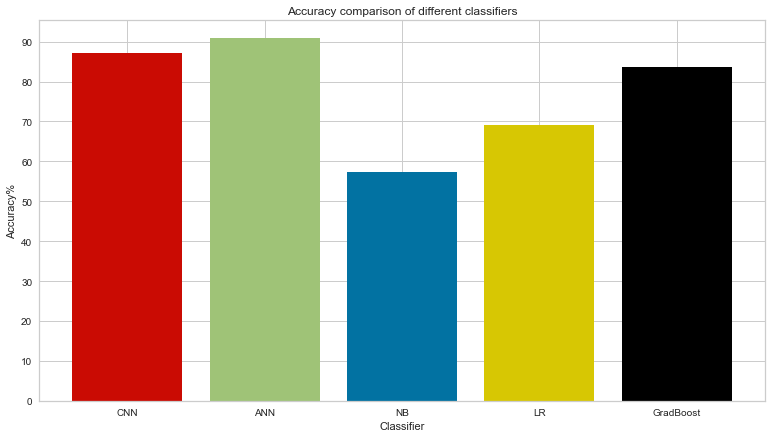

In [77]:
plt.style.use('seaborn-bright')
plt.figure(figsize=(13,7))
plt.bar(clfs,[i*100 for i in acc_seg],color=['r','g','b','y','black'])
plt.xlabel("Classifier")
plt.ylabel("Accuracy%")
plt.title("Accuracy comparison of different classifiers")
plt.yticks(np.arange(0, 100, 10))
plt.show()

##### ANN gives the best accuracy for segmented images, followed closely by CNN and GradientBoosting Classifier, while Naiive Bayes gives us the worst accuracy

#### Time

In [113]:
print(f"CNN: {times_seg[0]}")
print(f"ANN: {times_seg[1]}")
print(f"Naiive Bayes: {times_seg[2]}")
print(f"Logistic Regression: {times_seg[3]}")
print(f"GradientBoosting Classifier: {times_seg[4]}")

CNN: 178.78454279899597
ANN: 137.3814239501953
Naiive Bayes: 0.021019458770751953
Logistic Regression: 0.4634215831756592
GradientBoosting Classifier: 17.760946035385132


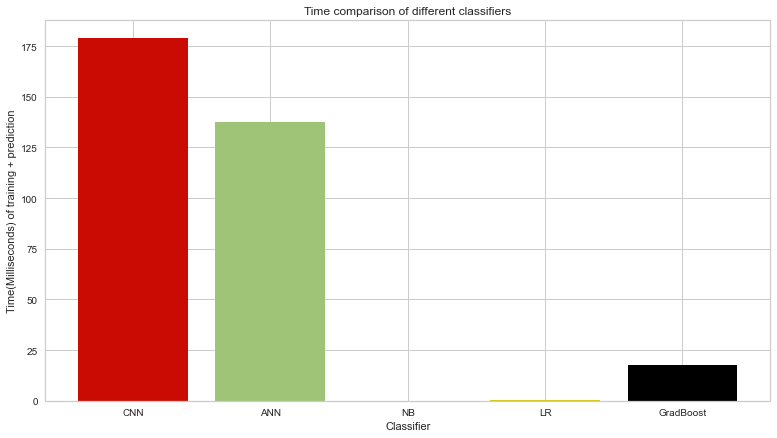

In [79]:
plt.style.use('seaborn-bright')
plt.figure(figsize=(13,7))
plt.bar(clfs,times_seg,color=['r','g','b','y','black'])
plt.xlabel("Classifier")
plt.ylabel("Time(Milliseconds) of training + prediction")
plt.title("Time comparison of different classifiers")
plt.show()

##### CNN and ANN take the most amount of time (keep in mind both of them were ran for 1000 epochs for segmented images), while Naiive Bayes and Logistic Regression were very fast by comparison

#### Recall

In [80]:
print(f"Naiive Bayes: {recall_seg[0]}")
print(f"Logistic Regression: {recall_seg[1]}")
print(f"GradientBoosting Classifier: {recall_seg[2]}")

Naiive Bayes: 0.5685836834733893
Logistic Regression: 0.6676792876241405
GradientBoosting Classifier: 0.8329056054239878


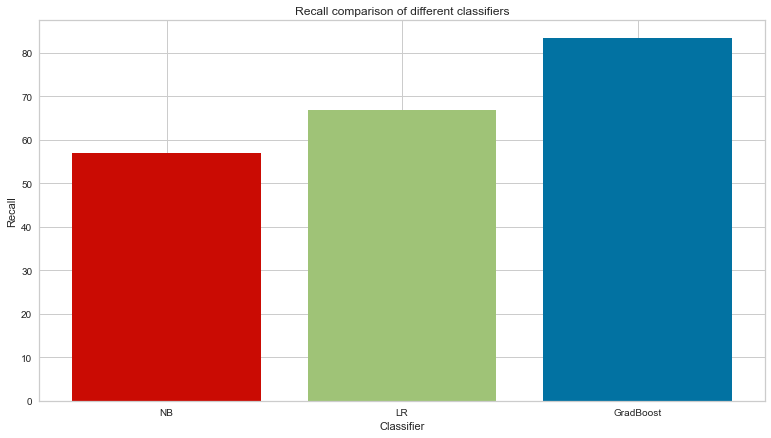

In [81]:
plt.style.use('seaborn-bright')
plt.figure(figsize=(13,7))
plt.bar(clfs2,[i*100 for i in recall_seg],color=['r','g','b'])
plt.xlabel("Classifier")
plt.ylabel("Recall")
plt.title("Recall comparison of different classifiers")
plt.show()

##### Gradient Boosting Classifier gives the best recall score for segmented images, followed by Logistic Regression and Naiive Bayes

#### Precision

In [82]:
print(f"Naiive Bayes: {prec_seg[0]}")
print(f"Logistic Regression: {prec_seg[1]}")
print(f"GradientBoosting Classifier: {prec_seg[2]}")

Naiive Bayes: 0.572494939271255
Logistic Regression: 0.7263410931174089
GradientBoosting Classifier: 0.8482534373838722


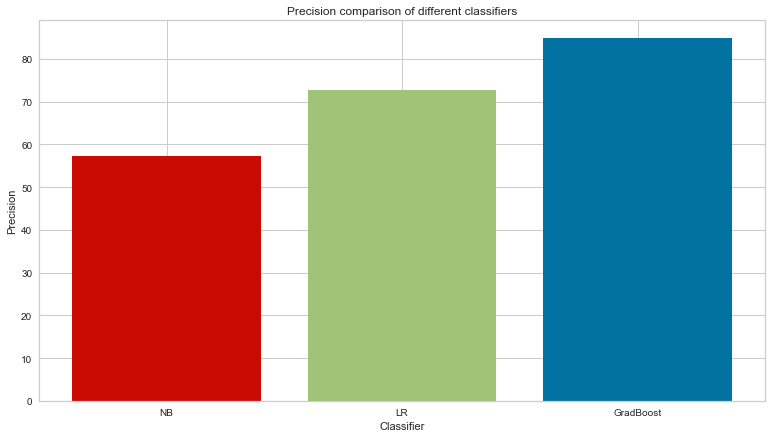

In [83]:
plt.style.use('seaborn-bright')
plt.figure(figsize=(13,7))
plt.bar(clfs2,[i*100 for i in prec_seg],color=['r','g','b'])
plt.xlabel("Classifier")
plt.ylabel("Precision")
plt.title("Precision comparison of different classifiers")
plt.show()

##### Gradient Boosting Classifier gives the best precision score for segmented images, followed by Logistic Regression and Naiive Bayes

#### F1 Score

In [84]:
print(f"Naiive Bayes: {f1_seg[0]}")
print(f"Logistic Regression: {f1_seg[1]}")
print(f"GradientBoosting Classifier: {f1_seg[2]}")

Naiive Bayes: 0.5377510366595462
Logistic Regression: 0.6568956628760865
GradientBoosting Classifier: 0.8362676735043295


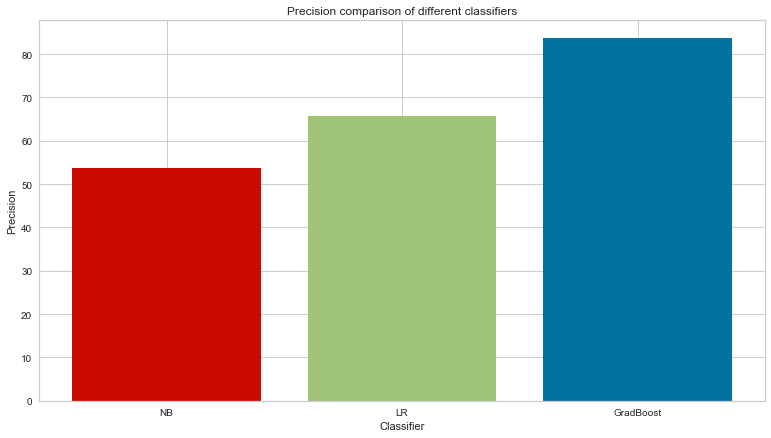

In [85]:
plt.style.use('seaborn-bright')
plt.figure(figsize=(13,7))
plt.bar(clfs2,[i*100 for i in f1_seg],color=['r','g','b'])
plt.xlabel("Classifier")
plt.ylabel("Precision")
plt.title("Precision comparison of different classifiers")
plt.show()

##### Gradient Boosting Classifier gives the best F1 score for segmented images, followed by Logistic Regression and Naiive Bayes

<br><br>
### Original Images

#### Accuracy

In [114]:
print(f"CNN: {acc_orig[0]}")
print(f"ANN: {acc_orig[1]}")
print(f"Naiive Bayes: {acc_orig[2]}")
print(f"Logistic Regression: {acc_orig[3]}")
print(f"GradientBoosting Classifier: {acc_orig[4]}")

CNN: 0.8838709677419355
ANN: 0.9419354838709677
Naiive Bayes: 0.8545454545454545
Logistic Regression: 0.7
GradientBoosting Classifier: 0.7272727272727273


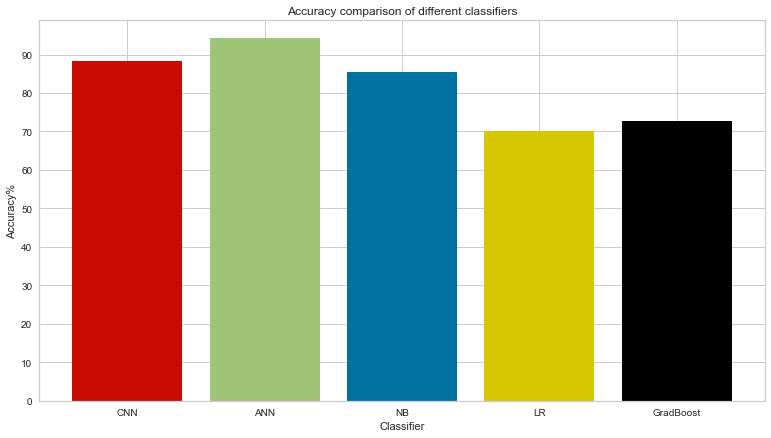

In [87]:
plt.style.use('seaborn-bright')
plt.figure(figsize=(13,7))
plt.bar(clfs,[i*100 for i in acc_orig],color=['r','g','b','y','black'])
plt.xlabel("Classifier")
plt.ylabel("Accuracy%")
plt.title("Accuracy comparison of different classifiers")
plt.yticks(np.arange(0, 100, 10))
plt.show()

##### ANN gives the best accuracy for original images, followed very closely by CNN and Naiive Bayes, while Logistic Regression gives us the worst accuracy

#### Time

In [115]:
print(f"CNN: {times_orig[0]}")
print(f"ANN: {times_orig[1]}")
print(f"Naiive Bayes: {times_orig[2]}")
print(f"Logistic Regression: {times_orig[3]}")
print(f"GradientBoosting Classifier: {times_orig[4]}")

CNN: 232.6942961215973
ANN: 231.2448844909668
Naiive Bayes: 0.021023988723754883
Logistic Regression: 0.4033651351928711
GradientBoosting Classifier: 25.40247416496277


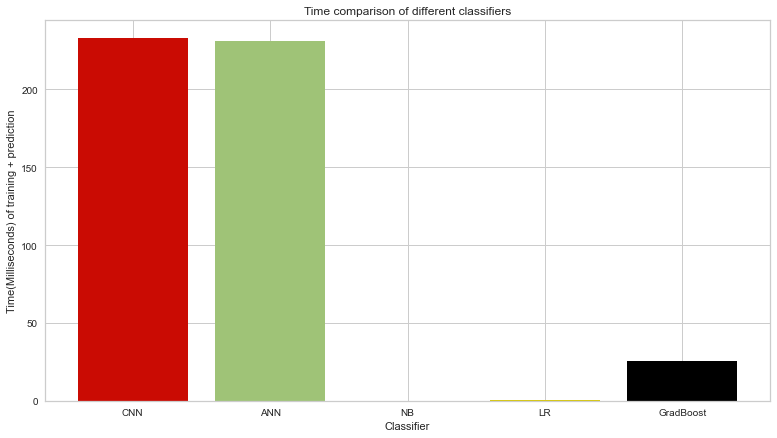

In [89]:
plt.style.use('seaborn-bright')
plt.figure(figsize=(13,7))
plt.bar(clfs,times_orig,color=['r','g','b','y','black'])
plt.xlabel("Classifier")
plt.ylabel("Time(Milliseconds) of training + prediction")
plt.title("Time comparison of different classifiers")
plt.show()

##### CNN and ANN take the most amount of time (keep in mind both of them were ran for ONLY 10 epochs for original images), while Naiive Bayes and Logistic Regression were very fast by comparison

#### Recall

In [90]:
print(f"Naiive Bayes: {recall_orig[0]}")
print(f"Logistic Regression: {recall_orig[1]}")
print(f"GradientBoosting Classifier: {recall_orig[2]}")

Naiive Bayes: 0.8343200916730329
Logistic Regression: 0.6949444550547492
GradientBoosting Classifier: 0.7300241119174943


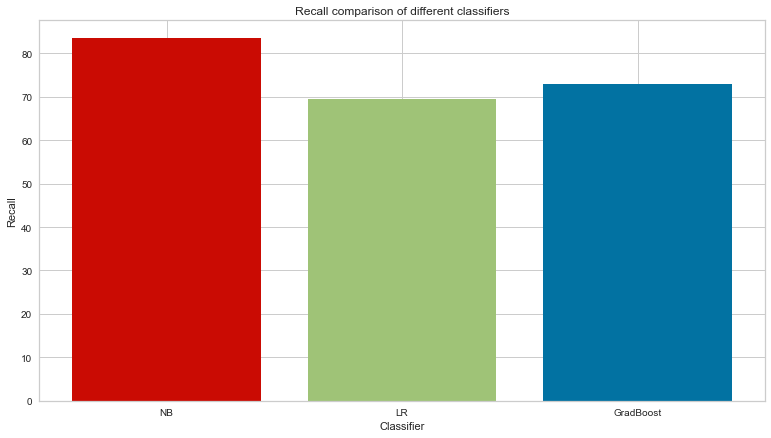

In [91]:
plt.style.use('seaborn-bright')
plt.figure(figsize=(13,7))
plt.bar(clfs2,[i*100 for i in recall_orig],color=['r','g','b'])
plt.xlabel("Classifier")
plt.ylabel("Recall")
plt.title("Recall comparison of different classifiers")
plt.show()

##### Naiive Bayes gives the best recall score for original images, followed by Gradient Boosting Classifer and Logistic Regression

#### Precision

In [92]:
print(f"Naiive Bayes: {prec_orig[0]}")
print(f"Logistic Regression: {prec_orig[1]}")
print(f"GradientBoosting Classifier: {prec_orig[2]}")

Naiive Bayes: 0.8536328933747412
Logistic Regression: 0.7308585164835165
GradientBoosting Classifier: 0.7792215392508585


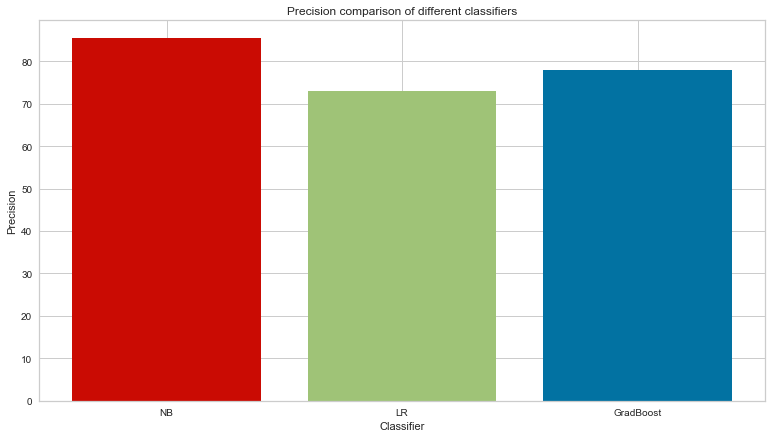

In [93]:
plt.style.use('seaborn-bright')
plt.figure(figsize=(13,7))
plt.bar(clfs2,[i*100 for i in prec_orig],color=['r','g','b'])
plt.xlabel("Classifier")
plt.ylabel("Precision")
plt.title("Precision comparison of different classifiers")
plt.show()

##### Naiive Bayes gives the best precision score for original images, followed by Gradient Boosting Classifer and Logistic Regression

#### F1 Score

In [94]:
print(f"Naiive Bayes: {f1_orig[0]}")
print(f"Logistic Regression: {f1_orig[1]}")
print(f"GradientBoosting Classifier: {f1_orig[2]}")

Naiive Bayes: 0.8383223995831754
Logistic Regression: 0.6969828402062244
GradientBoosting Classifier: 0.7409126984126984


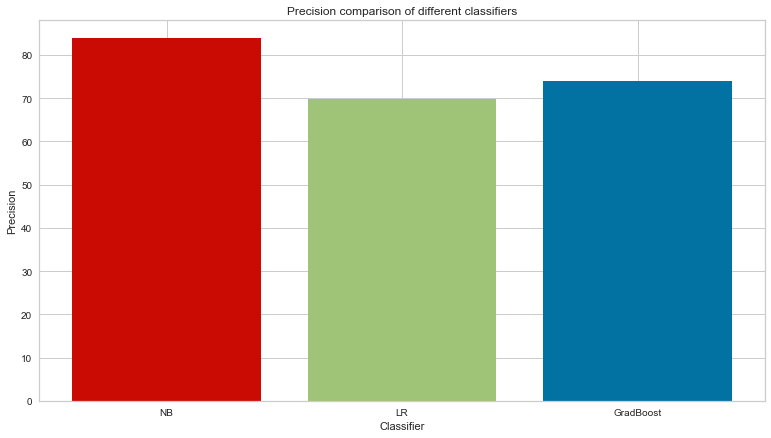

In [95]:
plt.style.use('seaborn-bright')
plt.figure(figsize=(13,7))
plt.bar(clfs2,[i*100 for i in f1_orig],color=['r','g','b'])
plt.xlabel("Classifier")
plt.ylabel("Precision")
plt.title("Precision comparison of different classifiers")
plt.show()

##### Naiive Bayes gives the best F1 score for original images, followed by Gradient Boosting Classifer and Logistic Regression

<br><br><br>
# Comparison of models with segmented and original images

#### Accuracy

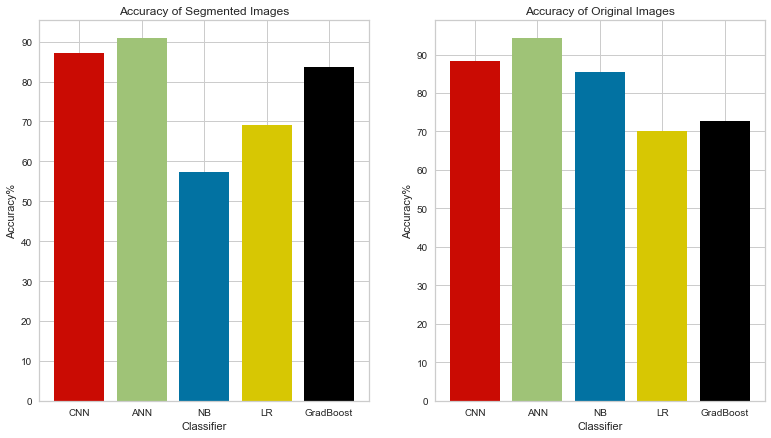

In [96]:
f, axs = plt.subplots(2,2,figsize=(13,7))
plt.subplot(1, 2, 1)
plt.style.use('seaborn-bright')
plt.bar(clfs,[i*100 for i in acc_seg],color=['r','g','b','y','black'])
plt.xlabel("Classifier")
plt.ylabel("Accuracy%")
plt.title("Accuracy of Segmented Images")
plt.yticks(np.arange(0, 100, 10))

plt.subplot(1, 2, 2)
plt.style.use('seaborn-bright')
plt.bar(clfs,[i*100 for i in acc_orig],color=['r','g','b','y','black'])
plt.xlabel("Classifier")
plt.ylabel("Accuracy%")
plt.title("Accuracy of Original Images")
plt.yticks(np.arange(0, 100, 10))

plt.show()

##### Max accuracy on non-segmented images is higher than of segmented images, as seen in the graph, where ANN's accuracy on orginal images is higher than of segmented images. However, other ML models, such as Gradient Boosting Classifier, work better on Segmented Images

#### F1 Score

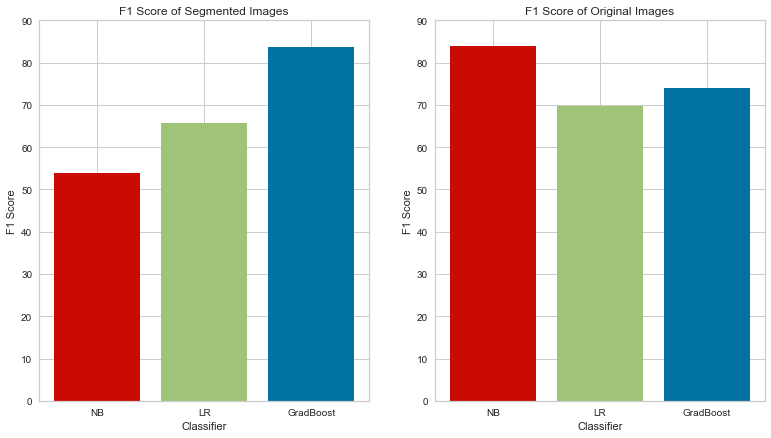

In [53]:
f, axs = plt.subplots(2,2,figsize=(13,7))
plt.subplot(1, 2, 1)
plt.style.use('seaborn-bright')
plt.bar(clfs2,[i*100 for i in f1_seg],color=['r','g','b'])
plt.xlabel("Classifier")
plt.ylabel("F1 Score")
plt.title("F1 Score of Segmented Images")
plt.yticks(np.arange(0, 100, 10))

plt.subplot(1, 2, 2)
plt.style.use('seaborn-bright')
plt.bar(clfs2,[i*100 for i in f1_orig],color=['r','g','b'])
plt.xlabel("Classifier")
plt.ylabel("F1 Score")
plt.title("F1 Score of Original Images")
plt.yticks(np.arange(0, 100, 10))

plt.show()

##### F1 Score is higher on Original Images, as compared with Segmented Images

#### Error Rate of Deep Learning Models

##### Segmented Images

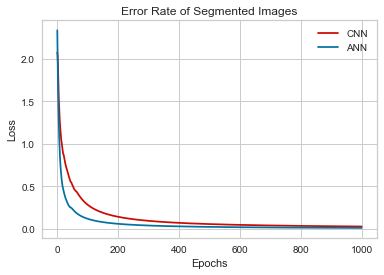

In [109]:
plt.plot(loss_cnn_seg,color='r',label='CNN')
plt.plot(loss_ann_seg,color='b',label='ANN')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Error Rate of Segmented Images")
plt.legend()
plt.show()

##### ANN converges faster than CNN on segmented images

##### Non-segmented Images

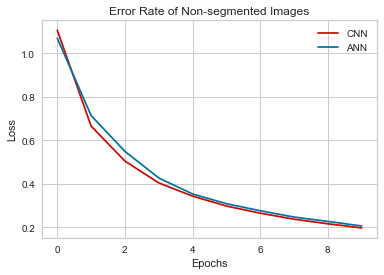

In [110]:
plt.plot(loss_cnn_orig,color='r',label='CNN')
plt.plot(loss_ann_orig,color='b',label='ANN')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Error Rate of Non-segmented Images")
plt.legend()
plt.show()

##### CNN converges faster than ANN on non-segmented images

### In conclusion, we can see that Deep Learning Models (CNN/ANN) performed better on Non-Segmented Images, whereas Classical ML Models (Naiive Bayes/Logistic Regression/GradientBoostingCLF) performed better on Segmented Images

### Moreover, ANN converges faster than CNN on segmented images, while CNN converges faster than ANN on non-segmented images